# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
n_train = len(X_train)
n_test = len(X_test)
n_classes = len(set(y_train) | set(y_test))
image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of classes =", n_classes)
print("Image data shape =", image_shape)

Number of training examples = 39209
Number of testing examples = 12630
Number of classes = 43
Image data shape = (32, 32, 3)


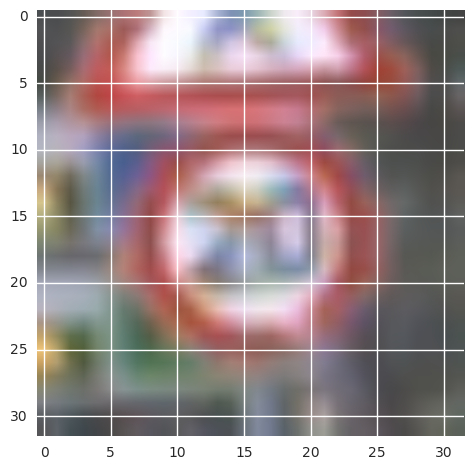

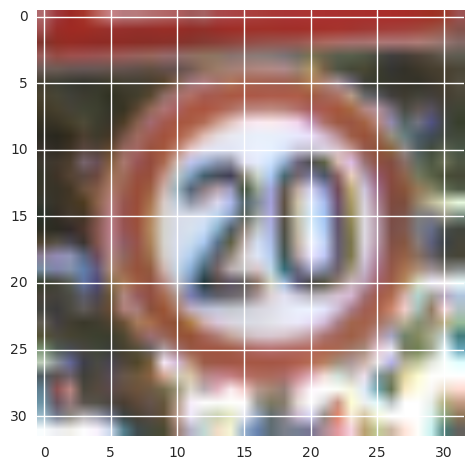

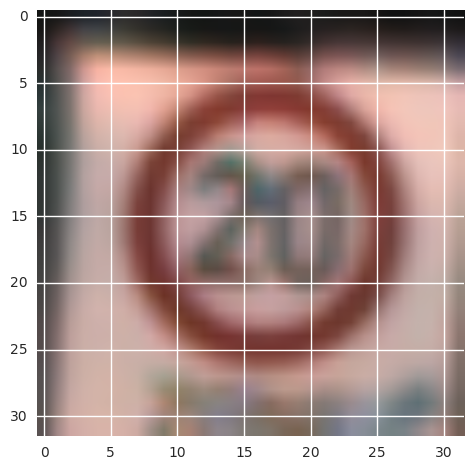

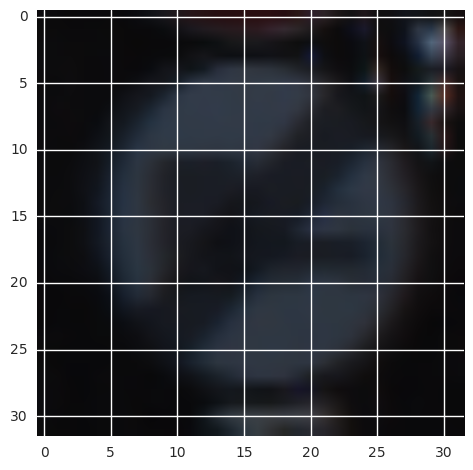

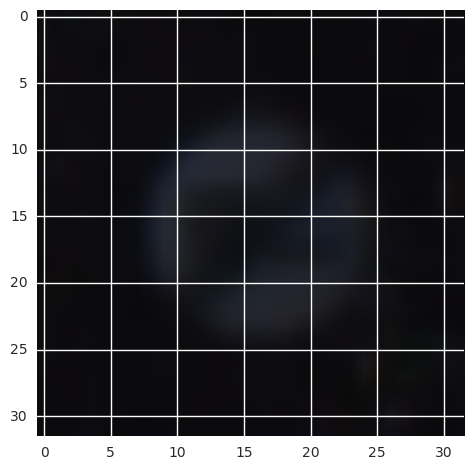

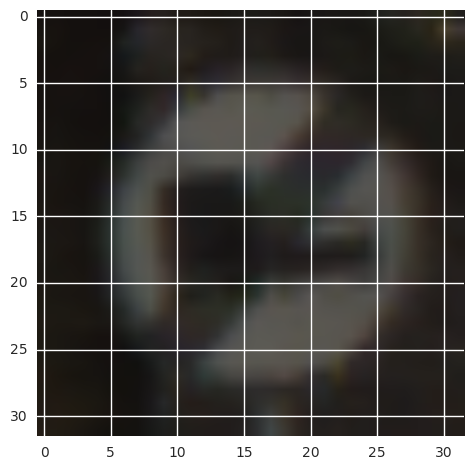

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(X_train[0])
plt.figure()
plt.imshow(X_train[50])
plt.figure()
plt.imshow(X_train[100])
plt.figure()
plt.imshow(X_train[-1])
plt.figure()
plt.imshow(X_train[-51])
plt.figure()
plt.imshow(X_train[-101])

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


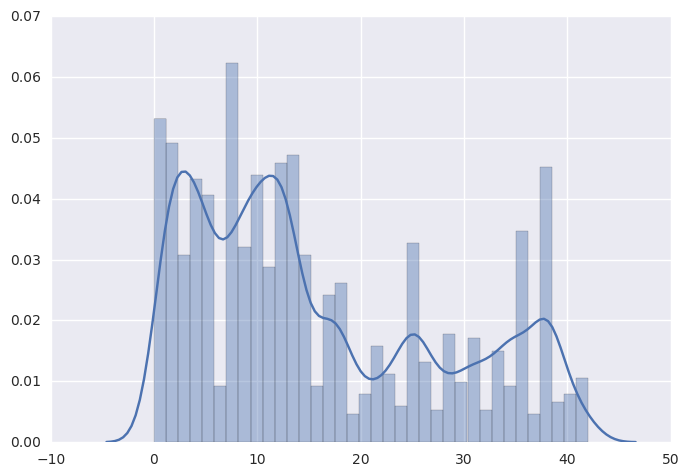

In [5]:
# view the (im)balance of class labels.
sns.distplot(y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

# input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Using TensorFlow backend.


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
I've kept the preprocessing to a minimum. The pixel values are converted to floating points between 0 and 1 and the targets are encoded as one-hot vectors. During training, we will jitter the images with Keras's `ImageDataGenerator`.

The values are converted to a continuous scale betwen 0 and 1 to improve the gradient based optimization routines (since the assumption is the function learned by the network is continuous in the input space). The jittering (small, random translations and rotations) should limit the models ability to memorize examples. 

I chose not to grayscale because I thought sign color might be indiciative in some cases.

In [7]:
from sklearn.model_selection import train_test_split
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

# jitter images
datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.03,
    height_shift_range=0.03)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I've selected two-thirds of the training data to use as a validation set. No additional data is generated.

In [8]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My neural network is a feedforward convolutional neural network. Using [1] as a guide, I use a simple architecture: 

   * Two stages of: CONV --> RELU --> CONV --> RELU --> POOL
   * Two densely connected sections, to an internal representation of dimension 512 and to the number of classes (43).
      
[1] http://cs231n.github.io/convolutional-networks/

In [126]:
from keras.callbacks import ModelCheckpoint
model.fit_generator(generator=datagen.flow(X_tr, Y_tr, batch_size=32),
          samples_per_epoch=X_tr.shape[0],
          nb_epoch=32,
          validation_data=(X_val, Y_val),
          callbacks=[ModelCheckpoint('cnn_model.h5',save_best_only=True)])

Epoch 1/32
31367/31367 [==============================] - 354s - loss: 2.4377 - acc: 0.3054 - val_loss: 0.6247 - val_acc: 0.8097
Epoch 2/32
31367/31367 [==============================] - 260s - loss: 0.6152 - acc: 0.7999 - val_loss: 0.1840 - val_acc: 0.9477
Epoch 3/32
31367/31367 [==============================] - 293s - loss: 0.3319 - acc: 0.8947 - val_loss: 0.0835 - val_acc: 0.9799
Epoch 4/32
31367/31367 [==============================] - 309s - loss: 0.2350 - acc: 0.9246 - val_loss: 0.0525 - val_acc: 0.9884
Epoch 5/32
31367/31367 [==============================] - 331s - loss: 0.1846 - acc: 0.9422 - val_loss: 0.0341 - val_acc: 0.9918
Epoch 6/32
31367/31367 [==============================] - 237s - loss: 0.1560 - acc: 0.9507 - val_loss: 0.0338 - val_acc: 0.9912
Epoch 7/32
31367/31367 [==============================] - 288s - loss: 0.1335 - acc: 0.9584 - val_loss: 0.0307 - val_acc: 0.9908
Epoch 8/32
31367/31367 [==============================] - 236s - loss: 0.1257 - acc: 0.9593 - val

In [9]:
model.load_weights("cnn_model.h5")
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0999655114794
Test accuracy: 0.980760094984


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
My network was trained with the Adam [2] optimizer, a batch size of 32, over 32 epochs. I also used drop-out with varying probabilities in the different layers of the network.

[2] https://arxiv.org/abs/1412.6980

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

In my first experiment, I used the architecture from [3] used on the MNIST dataset. The algorithm worked well but it was clear (after 12 epochs) that the network's capacity was too low to acheive the desired performance. I decided to add another convolutional section to the network and increase the dimensionality of the second-to-last layer, to give a richer internal representation of the images. I also initially failed to "jitter" the images -- doing so improved my generalizability. 

I am pleased with the results, and anticipate room for improvement given the simplicity of my approach. I plan on experimenting with the technique described in LeCunn & Sermanet wherein one passes the features from the "first stage" convolution features into the classifier at the end of the network.

[3] https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

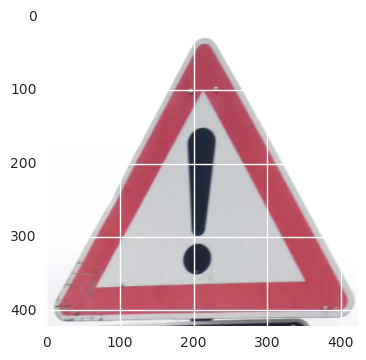

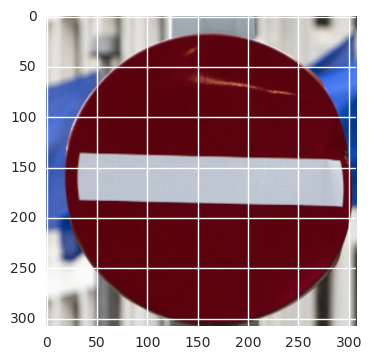

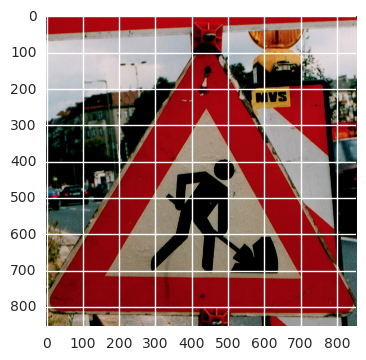

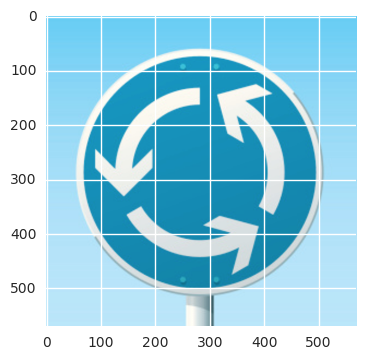

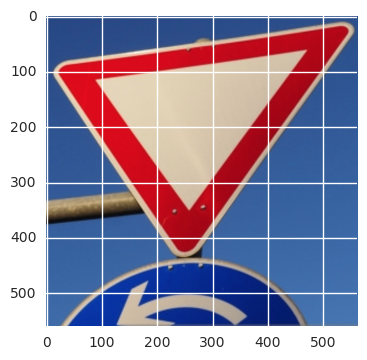

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import glob
%matplotlib inline

filelist = glob.glob('student_images/*.png')
img_array = [load_img(filename) for filename in filelist]
img = img_array[0]
for img in img_array:
    plt.figure()
    plt.imshow(img)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I didn't pick images that had these qualities, but some troubling features might be: poor lighting conditions, obstructed view, or angled shots.

In [11]:
small_img_array = [img.resize((32,32)) for img in img_array]
X_new = np.array([np.array(img).astype('float32')/255 for img in small_img_array])
print(X_new.shape)
preds = model.predict(X_new)

(5, 32, 32, 3)


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

My model correctly classified the five images I scraped from the web, with very high certainty on each prediction. I suspect it would struggle with a live camera stream without preprocessing to crop/center the traffic sign. My sample size of 5 is too small to _meaningfully_ compare performance, but it aced my quiz. 

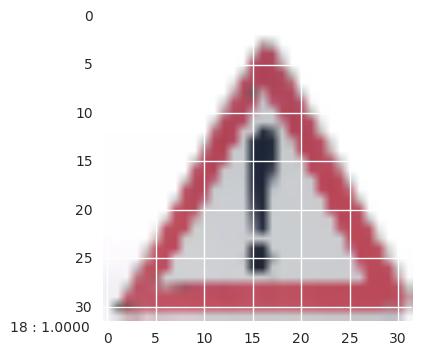

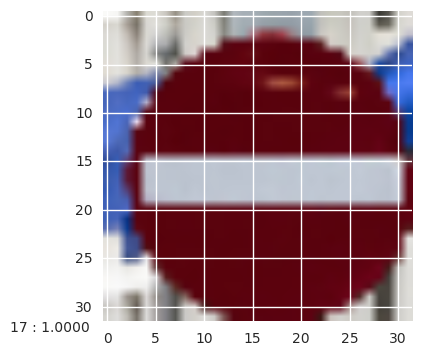

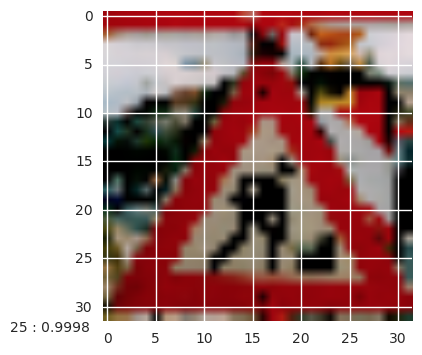

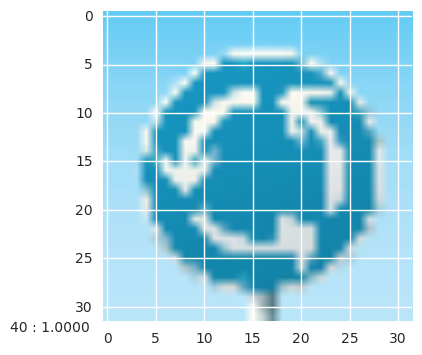

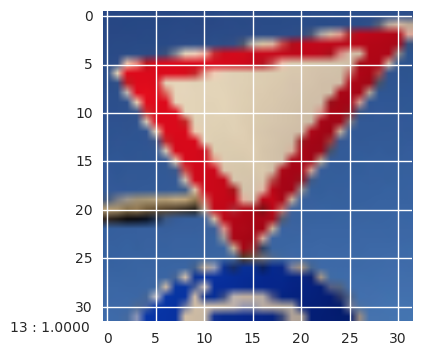

In [12]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
for (img, (answer, confs)) in zip(small_img_array, zip(list(map(np.argmax, preds)), preds)):
    fig = plt.figure()
    plt.imshow(img)
    fig.text(.1,.1, str(answer) + " : " + ("%0.4f" % confs[answer]))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

On the images I grabbed, the model was maximally certain on all except one, which was still correct and classified with high confidence. Here's a plot to appease the previous grader:

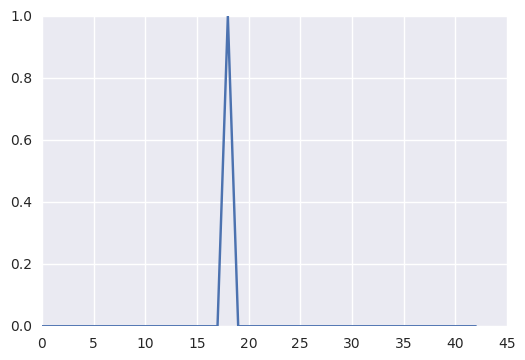

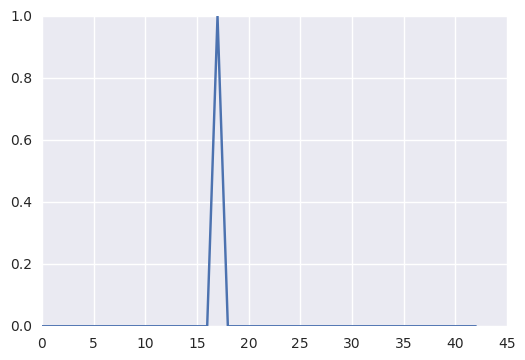

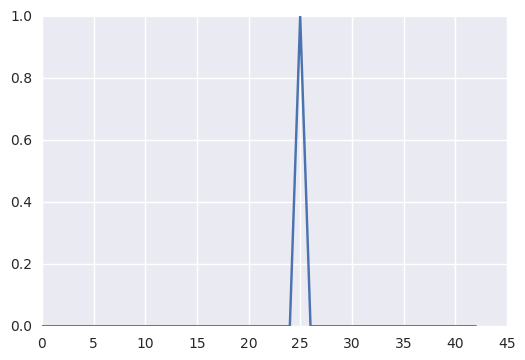

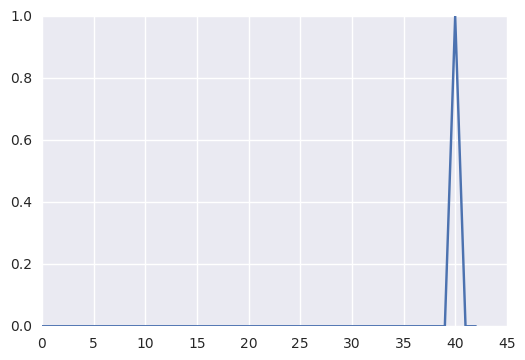

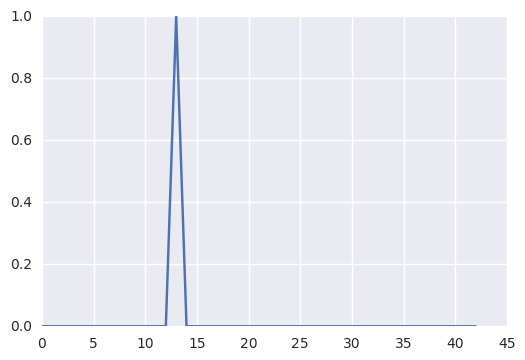

In [43]:
for pred in preds:
    plt.figure()
    plt.plot(range(len(pred)), pred)

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

I took screenshots, resized the images, and converted the pixel values to the [0,1]-scale used by the model.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.